In [1]:
import numpy as np
import pandas as pd
import os
import sys
import pickle
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

sys.path.append(os.path.abspath('..'))
sns.set_theme(style='whitegrid')

In [2]:
df = pd.read_csv('../infovis-project/processed_data/business_review_fused.gzip',compression='gzip',index_col=[0])
df_categories = pd.read_csv('../infovis-project/processed_data/business_category_counts.gzip',compression='gzip',index_col=[0])

In [3]:

# Handle nulls
# Set rows with 0 hours per week to NA
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'hours_per_week']

df[df['hours_per_week'] == 0][days] = np.nan

#Fill all numeric with mode
df.select_dtypes(include='number').fillna(df.select_dtypes(include='number').median(), inplace=True)

#Fill remainder with mode
null_columns = df.isnull().sum()[df.isnull().sum() > 0].index

for col in null_columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

# After filling NAs and 0s, recalculate hours per week.
df['hours_per_week'] = df['Monday'] + df['Tuesday'] + df['Wednesday'] + df['Thursday'] + df['Friday'] + df['Saturday'] + df['Sunday']

# Categorize if business is open on the weekend (Saturday and Sunday both)
df['open_weekends'] = ((df['Saturday'] > 0) & (df['Sunday'] > 0))

print(df['stars'].mean())

# Categorize if business is 'highly rated' (Above average)
df['highly_rated'] = df['stars'] >= df['stars'].mean()

df.head(10)

C:\Users\lkyoo\AppData\Local\Temp\ipykernel_5732\331619324.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df['hours_per_week'] == 0][days] = np.nan


3.5177245532321244


,business_id,name,city,state,latitude,longitude,stars,review_count,is_open,categories,...,star_3,star_4,star_5,review_dates,avg_review_age,est_business_age,hours_per_week,checkins,open_weekends,highly_rated
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,1,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",...,9,31,37,[numpy.datetime64('2013-10-05T15:19:06.0000000...,7.45,13.66,94.0,"2010-08-18 17:05:36, 2010-11-25 17:45:31, 2011...",True,True
1,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,Ashland City,TN,36.269593,-87.058943,2.0,6,1,"Burgers, Fast Food, Sandwiches, Food, Ice Crea...",...,0,2,0,[numpy.datetime64('2012-12-18T08:45:44.0000000...,5.07,8.22,84.0,"2012-12-16 05:27:33, 2013-02-15 04:00:46, 2013...",True,False
2,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,Affton,MO,38.565165,-90.321087,3.0,19,0,"Pubs, Restaurants, Italian, Bars, American (Tr...",...,1,7,3,[numpy.datetime64('2014-02-25T22:34:59.0000000...,9.47,2.25,67.0,"2012-04-16 22:28:12, 2012-04-20 22:38:55, 2012...",True,False
3,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,Nashville,TN,36.208102,-86.768170,1.5,10,1,"Ice Cream & Frozen Yogurt, Fast Food, Burgers,...",...,1,0,1,[numpy.datetime64('2016-11-11T04:01:28.0000000...,4.60,9.80,76.0,"2011-01-17 15:31:21, 2011-02-23 21:28:08, 2011...",True,False
4,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,Tampa Bay,FL,27.955269,-82.456320,4.0,10,1,"Vietnamese, Food, Restaurants, Food Trucks",...,2,2,6,[numpy.datetime64('2019-04-04T16:03:00.0000000...,3.35,3.45,23.0,"2018-07-19 20:23:33, 2019-07-12 15:37:41, 2019...",True,True
5,il_Ro8jwPlHresjw9EGmBg,Denny's,Indianapolis,IN,39.637133,-86.127217,2.5,28,1,"American (Traditional), Restaurants, Diners, B...",...,1,7,4,[numpy.datetime64('2016-05-08T08:49:25.0000000...,4.66,7.11,112.0,"2010-07-24 13:09:14, 2010-09-05 16:25:35, 2010...",True,False
6,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,Largo,FL,27.916116,-82.760461,4.5,100,0,"Food, Delis, Italian, Bakeries, Restaurants",...,1,18,74,[numpy.datetime64('2018-04-28T00:32:12.0000000...,7.19,9.40,58.0,"2010-08-26 17:52:51, 2011-02-13 00:43:54, 2011...",False,True
7,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,Philadelphia,PA,39.953949,-75.143226,4.0,245,1,"Sushi Bars, Restaurants, Japanese",...,29,50,142,[numpy.datetime64('2018-01-22T01:47:25.0000000...,3.57,4.14,53.0,"2017-11-25 02:28:19, 2017-11-28 23:17:19, 2017...",True,True
8,ROeacJQwBeh05Rqg7F6TCg,BAP,Philadelphia,PA,39.943223,-75.162568,4.5,205,1,"Korean, Restaurants",...,28,49,117,[numpy.datetime64('2016-10-27T01:10:32.0000000...,5.93,8.10,54.0,"2013-12-06 22:32:24, 2013-12-18 02:03:03, 2014...",False,True
9,WKMJwqnfZKsAae75RMP6jA,Roast Coffeehouse and Wine Bar,Edmonton,AB,53.546045,-113.499169,4.0,40,0,"Coffee & Tea, Food, Cafes, Bars, Wine Bars, Re...",...,4,22,8,[numpy.datetime64('2013-09-04T19:49:33.0000000...,9.15,3.05,67.0,"2012-07-30 18:35:27, 2012-08-11 20:40:23, 2012...",True,True


Data  visualization:  Visualize  the  dataset  using  the  following  plots  and  discuss  what  can  be
observed  from  each  plot. You  need  to  write  down your  observations  for  each plot  bellow. You
need to plot data using seaborn package and use hue for the categorical data.
a. Line-plot
b. Bar-plot : stack, group
c. Count-plot
d. Cat-plot
e. Pie-chart
f. Displot
g. Pair plot
h. Heatmap
i. Hist-plot
j. QQ-plot
k. Kernal density estimate
l. Scatter plot and regression line using sklearn
m.  Multivariate Box plot
n. Area plot ( if applicable)
o. Violin plot

In [4]:
# Line Plot
daily_hours = df[days + ['highly_rated']]

daily_hours = daily_hours.groupby('highly_rated').mean().T.drop(['hours_per_week'])

daily_hours.reset_index(inplace=True)

daily_hours_high = daily_hours.drop(False, axis=1)
daily_hours_high['Highly Rated'] = True

daily_hours_lo = daily_hours.drop(True, axis=1)
daily_hours_lo['Highly Rated'] = False

daily_hours = pd.concat([daily_hours_high, daily_hours_lo])

daily_hours[1].fillna(daily_hours[0], inplace=True)

daily_hours.drop([0], axis=1, inplace=True)

daily_hours.rename(columns={'index':'day',1:'hours'}, inplace=True)

daily_hours.reset_index(inplace=True)

daily_hours

highly_rated,index,day,hours,Highly Rated
0,0,Monday,5.664630,True
1,1,Tuesday,8.238392,True
2,2,Wednesday,8.728799,True
3,3,Thursday,8.930180,True
4,4,Friday,9.254495,True
5,5,Saturday,8.972665,True
6,6,Sunday,6.804945,True
7,0,Monday,7.701335,False
8,1,Tuesday,9.580775,False
9,2,Wednesday,9.769887,False


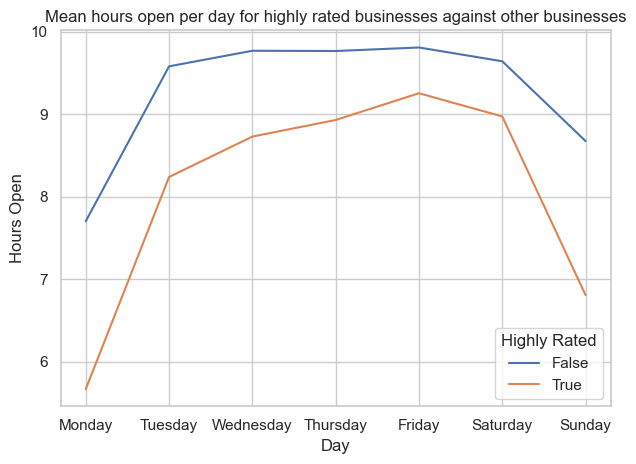

In [5]:
plt.figure()

sns.lineplot(data=daily_hours, x='day', y='hours', hue='Highly Rated')

plt.title('Mean hours open per day for highly rated businesses against other businesses')

plt.tight_layout()

plt.xlabel('Day')

plt.ylabel('Hours Open')

plt.show()

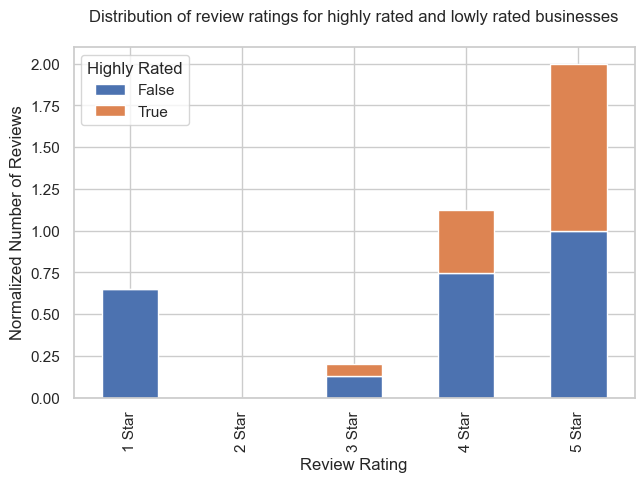

In [6]:
# Bar-plot : stack, group
df_stars = df.groupby('highly_rated').sum()[['star_1', 'star_2', 'star_3', 'star_4', 'star_5']].T

df_stars[False] = MinMaxScaler().fit_transform(np.array(df_stars[False]).reshape(-1,1))
df_stars[True] = MinMaxScaler().fit_transform(np.array(df_stars[True]).reshape(-1,1))

df_stars.plot(kind='bar', stacked=True)

plt.title('Distribution of review ratings for highly rated and lowly rated businesses\n')

plt.tight_layout()

plt.xlabel('Review Rating')

plt.xticks(range(0,5),['1 Star', '2 Star', '3 Star', '4 Star', '5 Star'])

plt.ylabel('Normalized Number of Reviews')

plt.legend(title='Highly Rated')

plt.show()

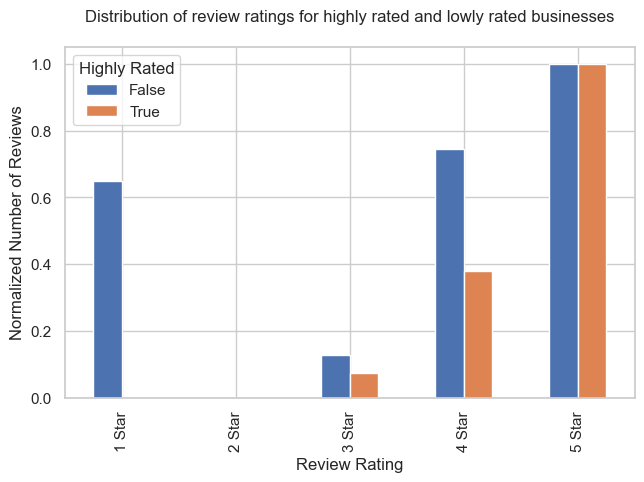

In [7]:
df_stars.plot(kind='bar')

plt.title('Distribution of review ratings for highly rated and lowly rated businesses\n')

plt.tight_layout()

plt.xlabel('Review Rating')

plt.xticks(range(0,5),['1 Star', '2 Star', '3 Star', '4 Star', '5 Star'])

plt.ylabel('Normalized Number of Reviews')

plt.legend(title='Highly Rated')

plt.show()

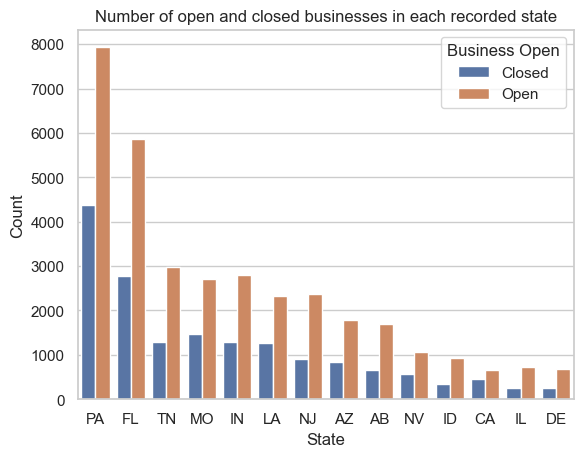

In [8]:
# Count-plot
sns.countplot(data=df, x='state', hue='is_open', order=df['state'].value_counts().index)

plt.title('Number of open and closed businesses in each recorded state')

plt.xlabel('State')
plt.ylabel('Count')

plt.legend(title='Business Open', labels=['Closed', 'Open'])

plt.show()

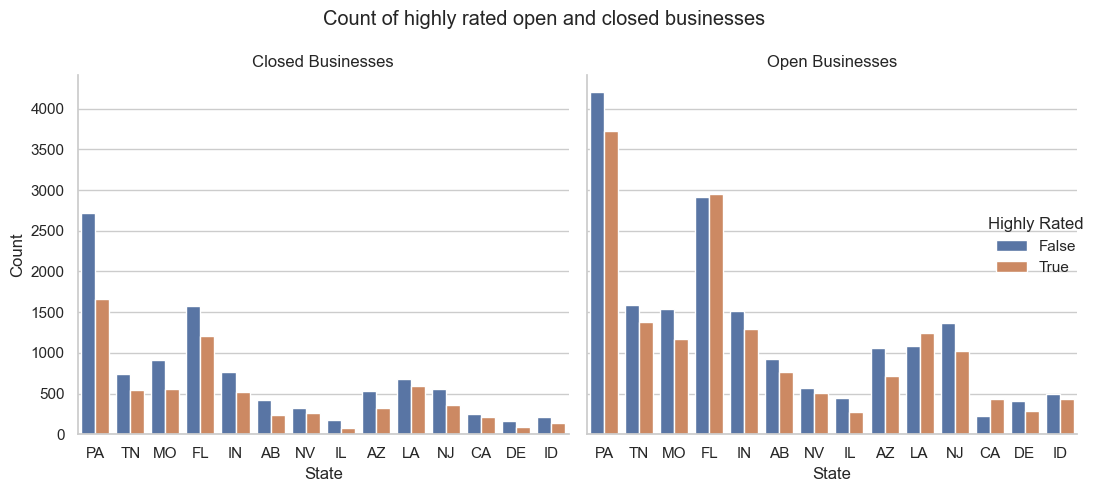

In [9]:
# Cat-plot
g = sns.catplot(x='state',
            col='is_open',
            hue='highly_rated',
            kind='count',
            data=df)

g.fig.axes[0].set_title('Closed Businesses')
g.fig.axes[1].set_title('Open Businesses')

g.legend.set_title('Highly Rated')

g.set_axis_labels('State','Count')

plt.suptitle('Count of highly rated open and closed businesses')

plt.tight_layout()

plt.show()

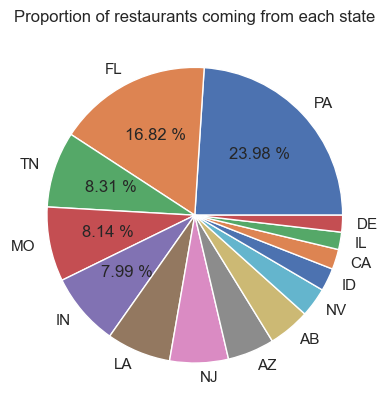

In [10]:
# Pie chart
def my_autopct(pct):
    return ('%.2f %%' % pct) if pct > 7.5 else ''


statecounts = df['state'].value_counts()
statecounts = statecounts[statecounts.values > 1]

plt.pie(statecounts, labels=statecounts.keys(), autopct=my_autopct)

plt.title('Proportion of restaurants coming from each state')

plt.show()


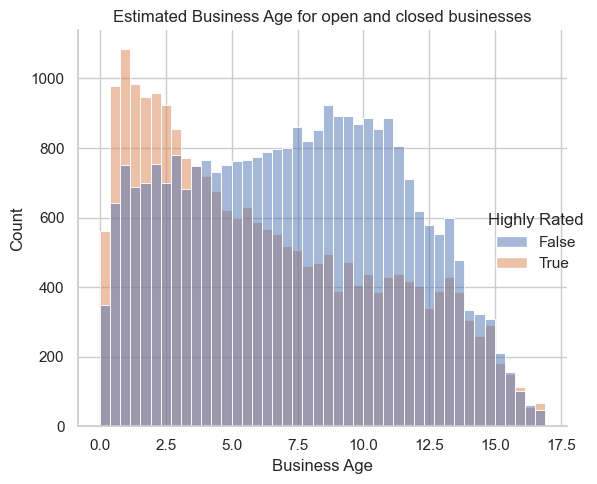

In [11]:
# Displot
g = sns.displot(df, x='est_business_age', hue='highly_rated')

plt.title('Estimated Business Age for open and closed businesses')

plt.xlabel('Business Age')

g.legend.set_title('Highly Rated')

plt.tight_layout()

plt.show()

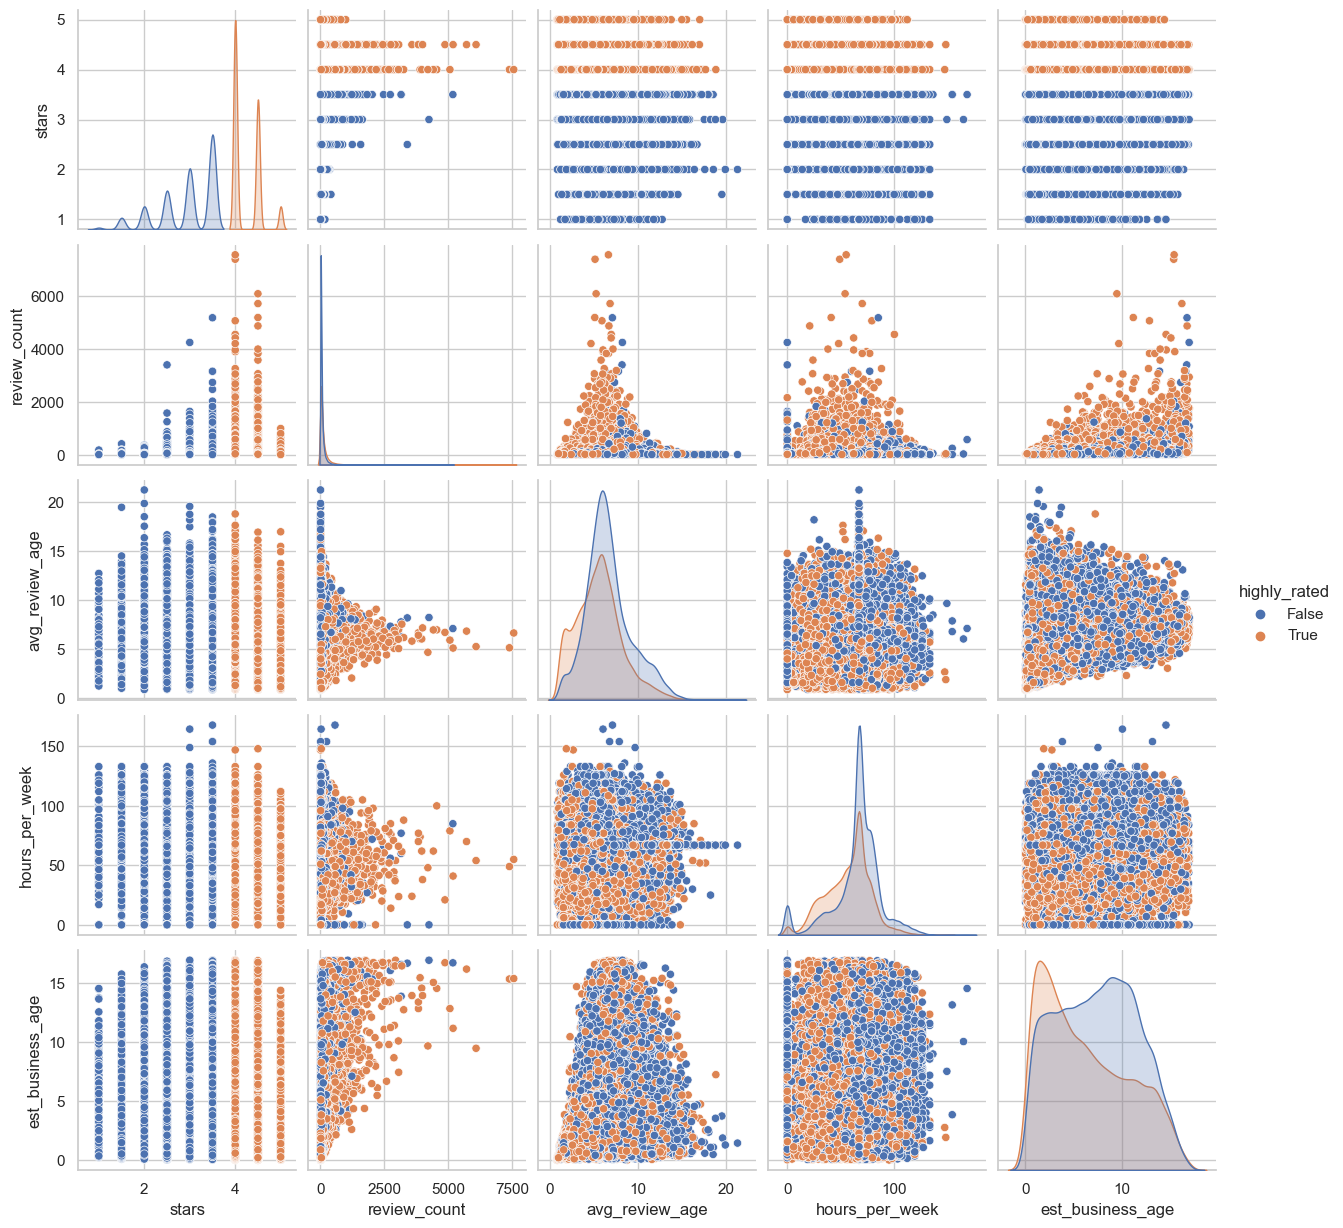

In [12]:
# Pair plot
sns.pairplot(data=df[['highly_rated','stars','review_count','avg_review_age','hours_per_week','est_business_age']], hue='highly_rated')
plt.show()

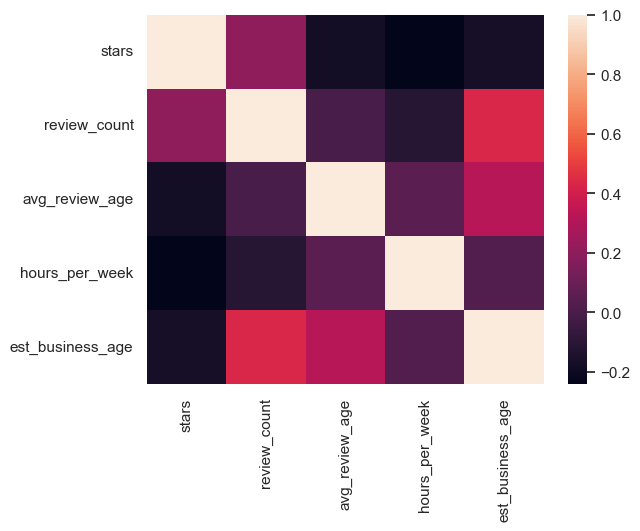

In [21]:
# Heatmap
df_corr = df[['stars','review_count','avg_review_age','hours_per_week','est_business_age']]

sns.heatmap(data=df_corr.corr(method='spearman'))

plt.show()

<Figure size 640x480 with 0 Axes>

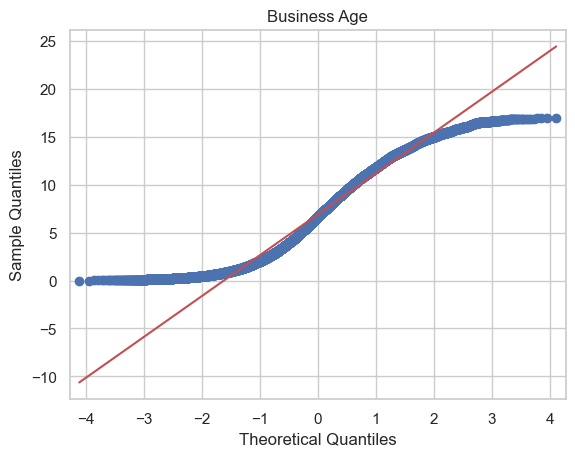

In [14]:
# QQ-plot
from statsmodels.graphics.gofplots import qqplot

plt.figure()
qqplot(df['est_business_age'],line='s')
plt.title('Business Age')
plt.show()


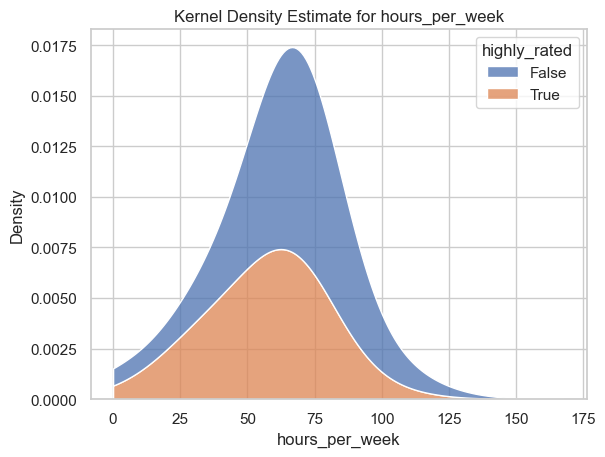

In [29]:
# Kernel density estimate
sns.kdeplot(data=df,
            x='hours_per_week',
            hue='highly_rated',
            bw_adjust=5,
            cut=0,
            multiple='stack')
plt.title('Kernel Density Estimate for hours_per_week')
plt.show()


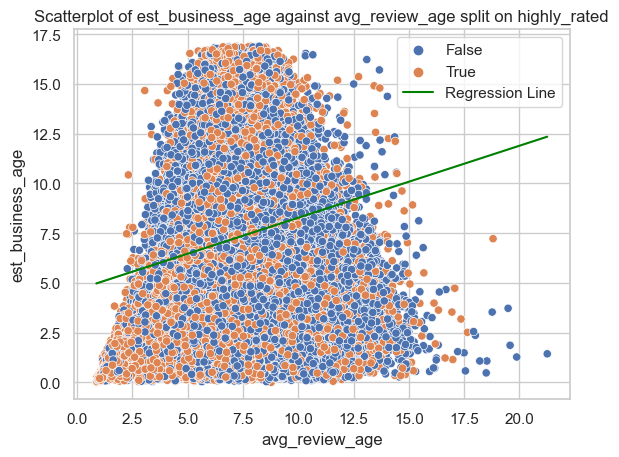

In [37]:
# Scatterplot with regression line
from sklearn import linear_model
regr = linear_model.LinearRegression()

X = np.array(df['avg_review_age'].values).reshape(-1,1)
Y = np.array(df['est_business_age'].values).reshape(-1,1)

regr = linear_model.LinearRegression()

regr.fit(X, Y)

Y_pred = regr.predict(X)

fig = plt.figure()

sns.scatterplot(data=df,
            x='avg_review_age',
            y='est_business_age',
            hue='highly_rated',
)

line_df = pd.DataFrame({'X':np.squeeze(X), 'Y_pred':np.squeeze(Y_pred)})

sns.lineplot(data=line_df, x='X',y='Y_pred', color='green', label='Regression Line')

plt.title('Scatterplot of est_business_age against avg_review_age split on highly_rated')

plt.show()

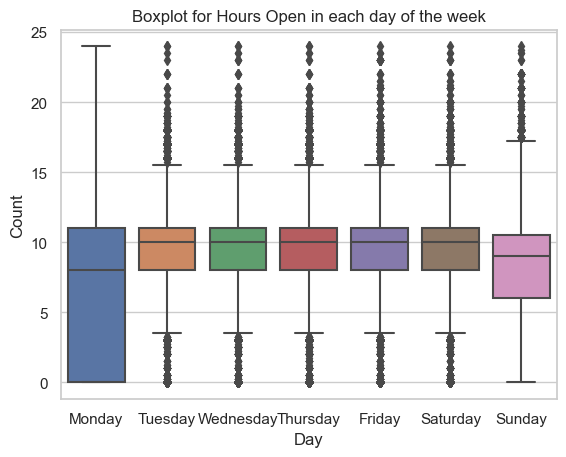

In [38]:
# Multivariate Boxplot
sns.boxplot(data=df[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']])
plt.title('Boxplot for Hours Open in each day of the week')
plt.ylabel('Count')
plt.xlabel('Day')
plt.show()

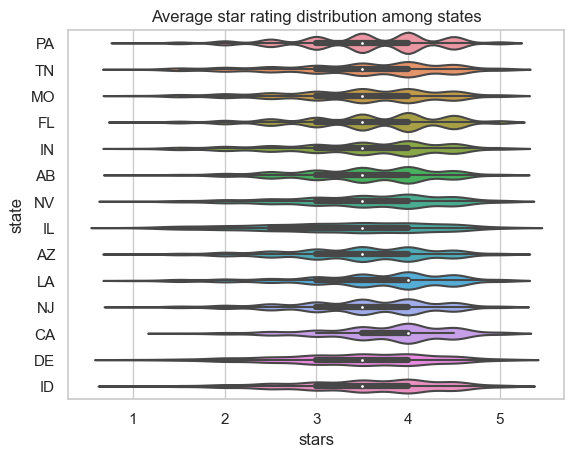

In [39]:
# Violin Plot
sns.violinplot(data=df, x="stars", y="state")
plt.title('Average star rating distribution among states')
plt.show()

C:\Users\lkyoo\AppData\Local\Temp\ipykernel_5732\206503229.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


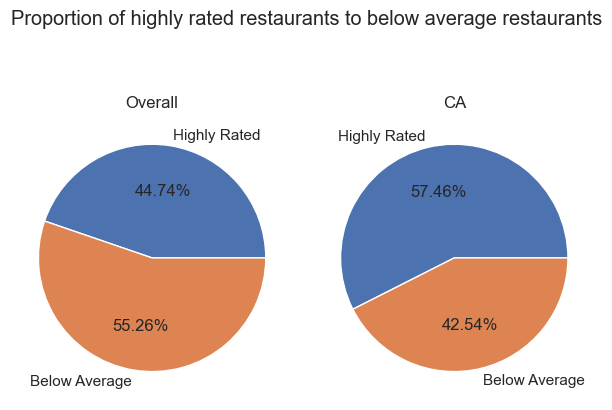

In [54]:
# Subplots: You need to provide subplots in your report that tell a story to a reader. Pick a method discussed in class.
fig, ax = plt.subplots(1, 2)

values_overall = [len(df[df['highly_rated'] == True]), len(df[df['highly_rated'] == False])]

values_ca = [len(df[(df['highly_rated'] == True) & (df['state'] == 'CA')]), len(df[(df['highly_rated'] == False) & (df['state'] == 'CA')])]

labels = ['Highly Rated', 'Below Average']

ax[0].pie(x=values_overall, labels=labels, autopct='%.2f%%')

ax[0].set_title('Overall')

ax[1].pie(x=values_ca, labels=labels, autopct='%.2f%%')

ax[1].set_title('CA')

fig.suptitle('Proportion of highly rated restaurants to below average restaurants')

plt.tight_layout()

fig.show()

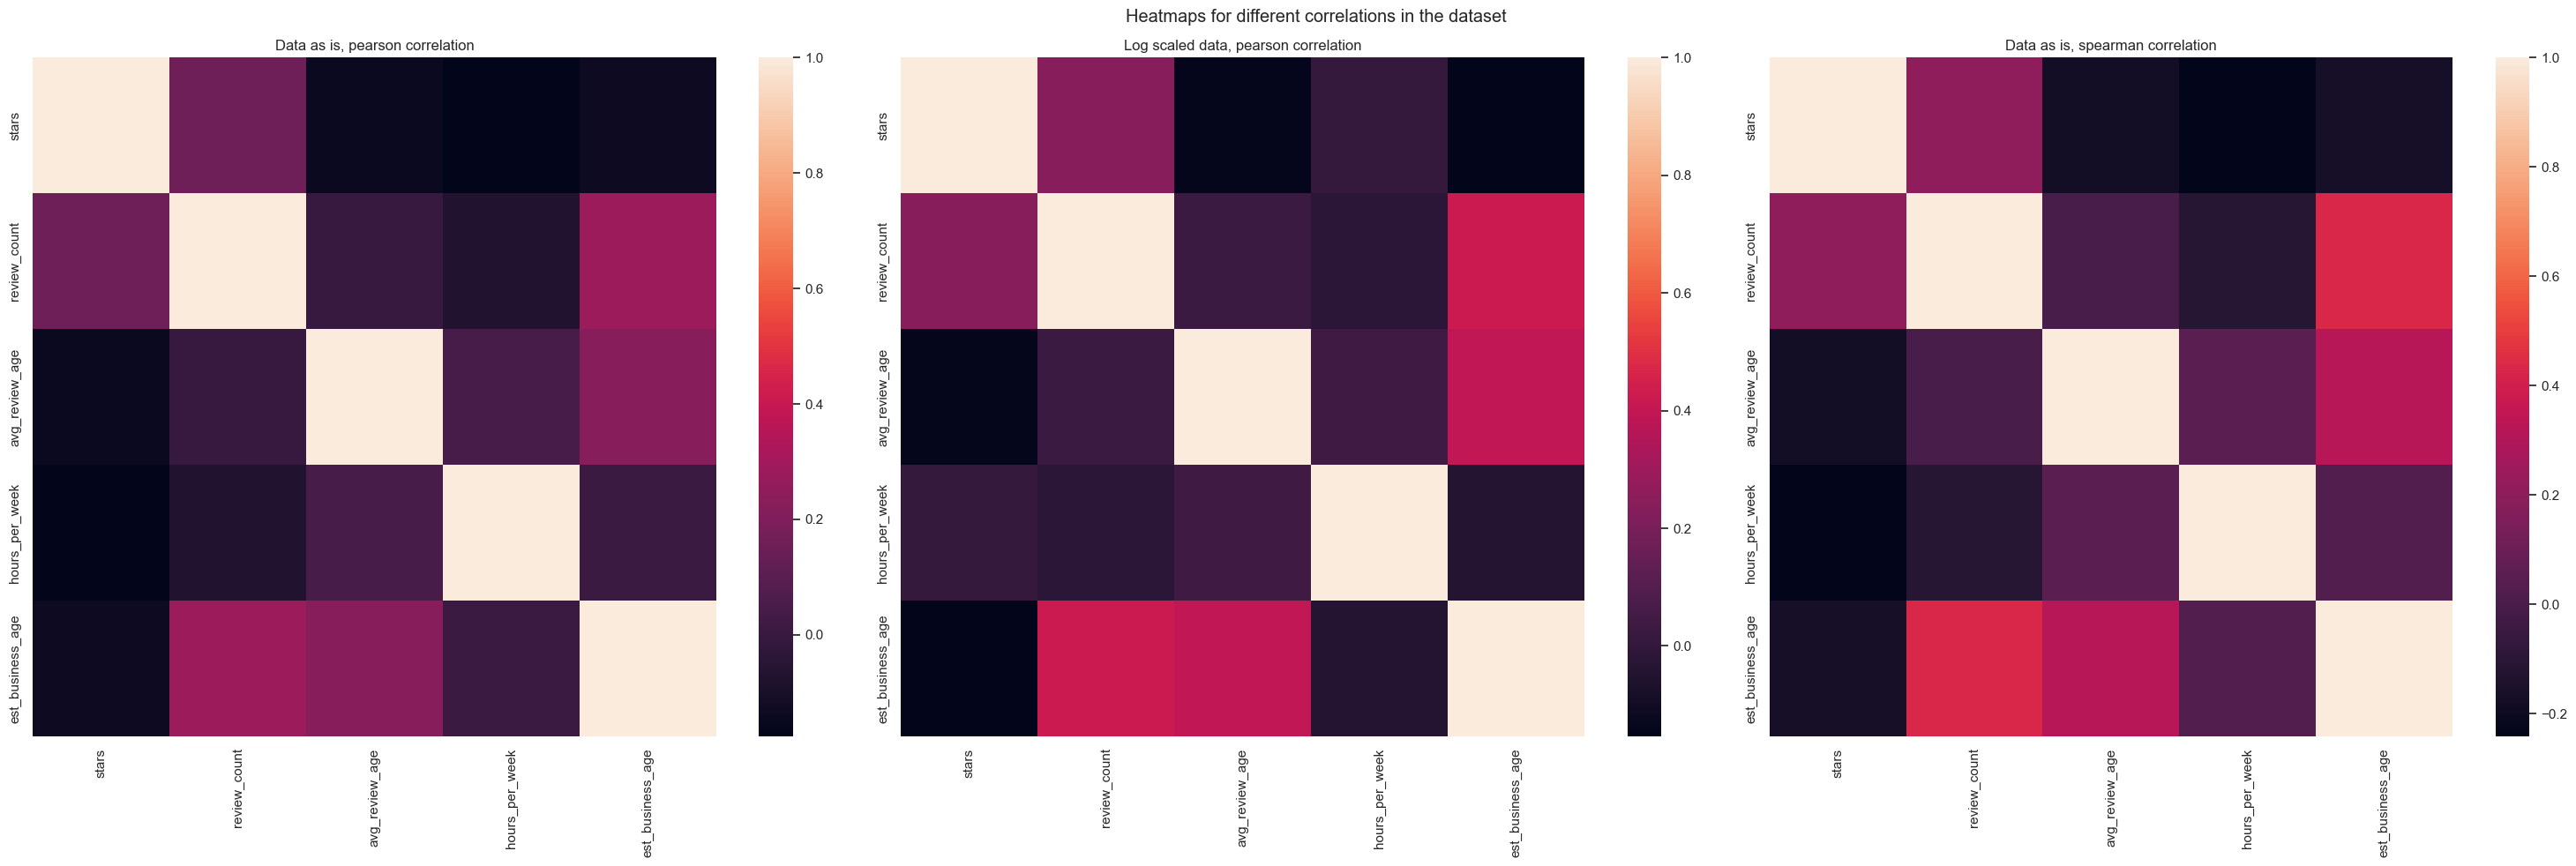

In [79]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

df_corr = df[['stars','review_count','avg_review_age','hours_per_week','est_business_age']]

df_corr_logged = np.sign(df_corr) * np.log(abs(df_corr) + 1)

sns.heatmap(ax=ax[0], data=df_corr.corr())

ax[0].set_title('Data as is, pearson correlation')

sns.heatmap(ax=ax[1], data=df_corr_logged.corr())

ax[1].set_title('Log scaled data, pearson correlation')

sns.heatmap(ax=ax[2], data=df_corr.corr(method='spearman'))

ax[2].set_title('Data as is, spearman correlation')

fig.suptitle('Heatmaps for different correlations in the dataset')

plt.tight_layout()

plt.show()